In [201]:
import numpy as np
f = open('live_record(1.567G, 50MHz, 25dB, 5M)_230513_2013_102s_SDR_검증.bin', 'rb')
data = np.fromfile(f, dtype=np.int16, count = int(50e6*10*2))
f.close()
# 측정값 오류로 인한 값들 양옆 중간값으로 치환
for i in range(0,len(data),250001):
    data[i] = (data[i-2]+ data[i+2]) / 2
    data[i+1] = (data[i-1] + data[i+3]) / 2

real = data[::2]
print(np.average(np.abs(real)))
imag = data[1::2]
print(np.average(np.abs(imag)))
signal_data = real + 1j*imag

# 최대 나올 수 있는 peak 약 1100만

157.931046974
157.938369832


In [202]:
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))


In [203]:
# 50MHz Sampling, 1.023MHz C/A code chip rate
# 50/1.023 samples per chip 
# Chip 마다 48 또는 49개의 sample이 생성된다는 건데 (48.87)
# 이 값들이 반복되는 주기를 구해야 함. 즉 (50 / 1.023) * X가 정수가 되기 위한 X의 최솟값
# 구해보면 1023 chip 마다 정수배가 되니까 (50000 sample 째에서 정수가 됨)
# C/A 코드 한 주기(1023 Chip 안에서 정해짐)
# 이만큼만 반복문 돌려서 각 chip당 몇 sample 넣을 건지 계산하면 됨

sample_count = []
cur = 0

for i in range(1,1024):
    cur = 50 * i /1.023
    sample_count.append(int(round(cur - round(50 * (i-1) / 1.023))))
    
#print(*sample_count)
#print(sum(sample_count))

In [204]:
# 기존 코드에서 가져와야 하는 것들
# 1. Replica 클래스 : C/A 코드 생성 적절하게 맞춰서 해야함 
# 그런데 이놈의 t는 어떻게 다뤄야 할지 생각해야 됨. 그냥 하면 되나?
# 2. Acquisition(일단 첫번째 목표), 위성번호는 matlab 파일에 나와 있으니까(5번이었나?)
# 해당 위성 번호 기준으로 Acquisition 돌렸을 때 제대로 peak가 나오는지 확인(가장 먼저 해야할 것)
# 더 이상 OV가 정수가 아니므로 코드들 적절하게 수정할 필요 있음
# 한 Chip 주기 당 50000개 sample(1ms), 한 bit면 백 만개 sample(0.02초, 20ms, chip 주기 20번)

In [205]:
class Replica:
    def __init__(self, code_delay, doppler_freq, IF_freq, svNumber, t0): # t0 = 이전 carrier의 마지막 phase. 교수님이 그려 주신 그림에서 Φ_n 말하는 거임 
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip, cnt in zip(ca_code, sample_count) for _ in range(cnt)] # chip 당 해당하는 sample 개수 만큼 늘이기
        self.delayed_code = np.roll(ca_code, code_delay)
        
        self.t = np.arange(0, 50001) / (50e6)            # 한 주기 당 50000개 sample, 가장 뒷 자리는 밑에서 뺄 거임. 그래서 50001
                                                            # 분모 부분은 t가 0 ~ 1ms 범위가 되도록 조절해 준 거임
                                                            # => 가 아니라 sampling 주파수(fs)로 나눠줘야 함. 잘못적었네
                                                            
        temp = np.exp(1j * 2 * np.pi * (doppler_freq + IF_freq) * self.t) * t0   
        self.oversampled_signal = temp[:-1]
        
        self.last = temp[-1] # 다음 replica에서 사용할 Φ_(n+1) (누적)
        
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

In [206]:
class MA_Filter:
    def __init__(self, signal, IF_freq):
        self.t = np.arange(0, 100000) / (50e6)
        base_carrier = np.exp(-1j * 2 * np.pi * IF_freq * self.t)
        self.BB_signal = signal * base_carrier
    
    def extract(self, doppler_freq):
        
        # Doppler frequency로 내리기
        e = np.exp(-1j * 2 * np.pi * doppler_freq * self.t)
        target = self.BB_signal * e
        
        # 절반 chip 만큼씩 step을 밟으면서, 1chip 길이의 합을 저장
        Ma = []
        pos = 0
        i = 0
        half = 1
        # 두 바퀴
        doublecount = sample_count + sample_count
        try:
            while pos < 100000:
                if doublecount[i] == 48:
                    m = np.sum(target[pos:pos + 48])
                    Ma = np.append(Ma, m)
                    pos += 24
                elif doublecount[i] == 49:
                    if half == 1:
                        m = np.sum(target[pos:pos + 49])
                        Ma = np.append(Ma, m)
                        pos += 24
                    else:
                        m = np.sum(target[pos:pos + 49])
                        Ma = np.append(Ma, m)
                        pos += 25
                if half == -1:
                    i += 1
                half *= -1
                
        except IndexError:
            np.append(Ma,np.sum(signal_data[99975:100024]))
          
        # 검사(길이가 4092인지)
        # print('length : ', len(Ma))
        return Ma
                    

In [207]:
def acquisition(signal, code_delay_range, doppler_freq_range, IF_freq, svNumber):
    
    print('========== Acquisition Process ==========')
    frac_signal = signal[:100000]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset '대략적으로' 찾기)

    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Ma = MA_Filter(frac_signal, IF_freq)

    code = codes[svNumber]
    for i, doppler_freq in enumerate(doppler_freq_range):
        
        # 시간측정용
        print(f"Checking for {int(doppler_freq)}Hz...", end = " ")
        
        target = Ma.extract(doppler_freq)
        
        for j, code_delay in enumerate(code_delay_range):
            
            # Target의 간격은 반 chip
            current_pos = target[j:j+2046:2]
            
            # Correlation
            cor = np.abs(np.sum(current_pos * code))
            peak = np.max(cor) 
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
        print("Done")

    
    print('-'*40)
    print('Frame Sync complete.')
    print('Frame delay :', max_code_delay)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    return max_code_delay, max_doppler_freq, corr_matrix

In [208]:
code_delay_range = np.arange(0, 1023, 0.5) # 50000 sample을 2046개로 나눔 (0.5chip 간격)
doppler_freq_range = np.linspace(-5000, 5000, 21)
IF_freq = 8.42e6

# 들어있는 위성 번호 : 5, 11, 13, 15, 20.
svNumber = 11

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix = acquisition(signal_data, code_delay_range, doppler_freq_range, IF_freq, svNumber - 1)

========== Acquisition Process ==========
Checking for -5000Hz... Done
Checking for -4500Hz... Done
Checking for -4000Hz... Done
Checking for -3500Hz... Done
Checking for -3000Hz... Done
Checking for -2500Hz... Done
Checking for -2000Hz... Done
Checking for -1500Hz... Done
Checking for -1000Hz... Done
Checking for -500Hz... Done
Checking for 0Hz... Done
Checking for 500Hz... Done
Checking for 1000Hz... Done
Checking for 1500Hz... Done
Checking for 2000Hz... Done
Checking for 2500Hz... Done
Checking for 3000Hz... Done
Checking for 3500Hz... Done
Checking for 4000Hz... Done
Checking for 4500Hz... Done
Checking for 5000Hz... Done
----------------------------------------
Frame Sync complete.
Frame delay : 628.0
Estimated_Frequency Offset : -2000.0
Max correlation : 479138.2515706357
----------------------------------------


In [209]:
# 지금 peak 값이 떠야 하는데, 안 뜨고 있는 상황임

# 24.09.16  t 범위 잘못 잡아서 안나오는 거였습니다 
#           peak값은 바닥에 깔린 값들에 비해 약 두 배정도 차이 있는 것 같음
#           그럼 SNR 값도 계산이 가능한가?
#           다만 지금 svNumber = 5, 20일 때만 peak가 뜨는 것 같음

# 24.09.27  Moving Average Filter 적용 성공
#           실행시간 17~18초에서 3초로 감소
#           하지만 peak 안뜨는 건 그대로

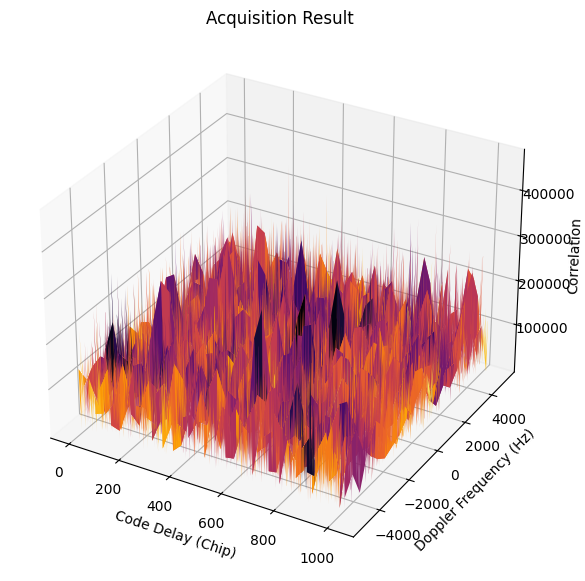

In [210]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='inferno_r')
ax.set_xlabel('Code Delay (Chip)')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Acquisition Result')
plt.show()